In [14]:
import ast
import requests

import folium 
import unicodedata
import pandas as pd
import numpy as np
import geopandas as gpd
import plotly.express as px
import plotly.io as pio
import seaborn as sns
from scipy.stats import mode
from itertools import permutations
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import matplotlib as mpl
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
from mlxtend.preprocessing import TransactionEncoder
from matplotlib.colors import ListedColormap

from scripts.hillclimbing import hill_climbing

sns.set_theme(style='darkgrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

map_palette = ListedColormap(sns.color_palette(['steelblue', 'midnightblue', 'lightseagreen', 'slateblue']).as_hex())

In [15]:
%%capture
!pip install openpyxl
!pip install kaleido

In [16]:
#Helper functions
def format_str(s):
    return str.upper(''.join(c for c in unicodedata.normalize('NFD', s)
                             if unicodedata.category(c) != 'Mn'))

def get_line(row):
    return [[row['DepLongitude'], row['DepLatitude']],
            [row['CELongitude'], row['CELatitude']]]

#Parâmetros
MIN_SUPPORT = 5e-3
MIN_CONFIDENCE = 0.8

# Motivação

Avaliar o trabalho feito pela Nepomuceno.

In [17]:
distributions = pd.read_csv('data/distributions.csv', parse_dates=['DataEmissaoCte'])

#Metadata com informações das colunas anteriores
metadata = pd.read_csv('data/metadata.csv')
# metadata

# Tratamento e Limpeza

Com isso decidimos trabalhar com a variável Rota como identificador. 
Em relação a tratamento e limpeza dos dados, foram feitas:
- **Sobre valores faltantes**: Todos os valores nulos foram removidos.
- **Sobre entregas com pesos fora do especificado**: Foram levadas em consideração apenas entregas com peso de transporte **entre 11000 e 13000 kilos**.

In [18]:
# Dropar rotas NaN
distributions = distributions.dropna(axis=0, subset=['Rota'])
distributions['Rota'] = pd.to_numeric(distributions['Rota'], downcast='integer')

# Essa cidade não está no dataset com 'Z'
distributions.loc[distributions.CidadeEntrega=='DONA EUZEBIA', 'CidadeEntrega'] = 'DONA EUSEBIA'

# Filtrar pelo peso
filter_by_weight = distributions.groupby('Rota').PesoTransp.sum().to_frame().query('PesoTransp <= 13000 and PesoTransp >= 11000')

qtd_data = len(distributions)
distributions = distributions.loc[distributions.Rota.isin(filter_by_weight.index)]
new_qtd_data = len(distributions)

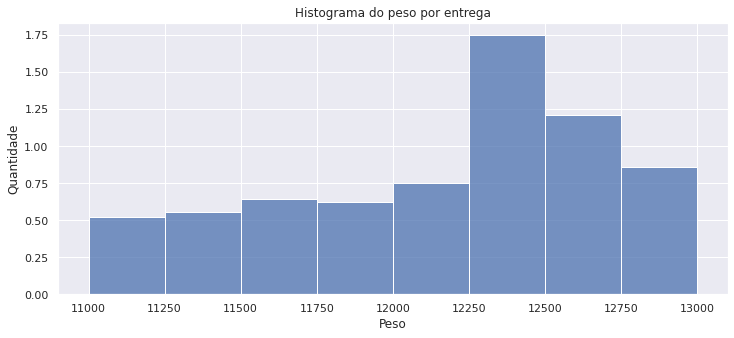

In [19]:
fig = plt.figure(figsize=(12, 5))

data = distributions.groupby('Rota').PesoTransp.sum().to_frame()
min_data, max_data = int(data.PesoTransp.min()), int(data.PesoTransp.max())

ax = sns.histplot(x='PesoTransp', data=data, stat='frequency', 
                  bins=np.arange(min_data, max_data + 250, 250))
ax.set_title('Histograma do peso por entrega')
ax.set(xlabel='Peso', ylabel='Quantidade')

plt.show()

- Como resultado da etapa da de limpeza de dados estamos trabalhando com **22% de dados do conjunto original**.
- Mais de **50%** das entregas possuem cargas acima de **12 toneladas**.

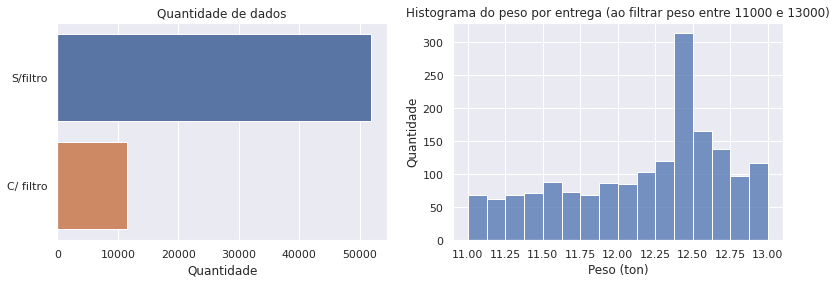

In [20]:
fig = plt.figure(figsize = (13, 4))

fig.add_subplot(1, 2, 1)
ax = sns.barplot(x=[qtd_data, new_qtd_data], y=['S/filtro', 'C/ filtro'])
ax.set_title('Quantidade de dados')
ax.set(xlabel='Quantidade')

fig.add_subplot(1, 2, 2)
ax = sns.histplot(x=0, data=filter_by_weight.apply(lambda x: x.PesoTransp/1000, axis=1).to_frame())
ax.set_title('Histograma do peso por entrega (ao filtrar peso entre 11000 e 13000)')
ax.set(xlabel='Peso (ton)', ylabel='Quantidade')
plt.show()

# Análise Exploratória de dados
```{admonition} Atenção
:class: attention
Todas as análises foram feitas considerando apenas entregas com o peso de transporte entre 11000 e 13000 kilos.
```

## Cidades

In [21]:
county_df_total = gpd.read_file('data/brazil_geospatial_dataset/Munic.shp')
county_df = county_df_total.loc[county_df_total.UF=='MG'].copy()
county_df['NOME'] = county_df.NOME.apply(format_str)

counties_activity = county_df[['NOME', 'LATITUDE', 'LONGITUDE', 'geometry']]
counties_activity.columns = ['Nome', 'Latitude', 'Longitude', 'geometry']
counties_activity = counties_activity.astype({'Latitude':float, 'Longitude':float})

annual_dist = pd.DataFrame(distributions.groupby(['CidadeEntrega']).Rota.count())
annual_dist.columns = ['DistAnnual']
counties_activity = pd.merge(counties_activity, annual_dist, left_on='Nome', right_on='CidadeEntrega', how='left').fillna(0)
counties_activity = counties_activity.sort_values(by='DistAnnual', ascending=False)

### Quais foram as cidades com maior quantidade de entregas?

- A cidade de **JUIZ DE FORA** recebeu mais entregas em um ano do que as outras cidades.

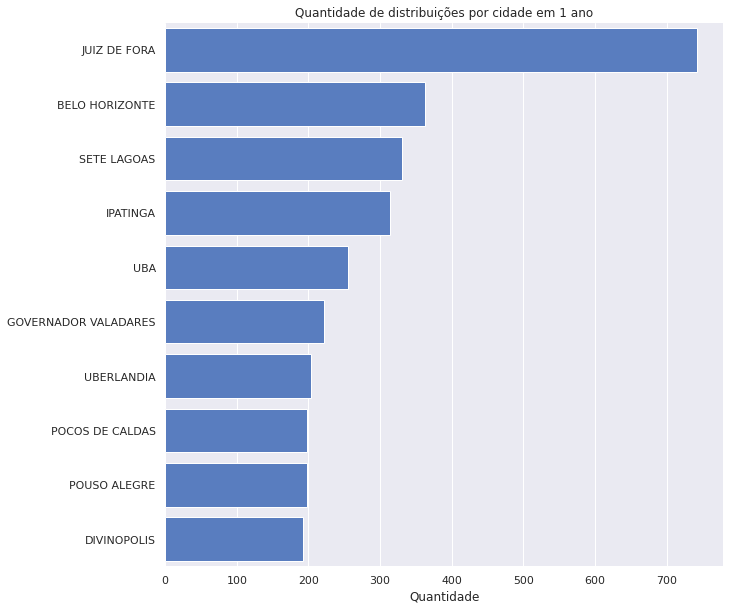

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.set_color_codes("muted")
sns.barplot(x="DistAnnual", y="Nome", data=counties_activity[:10], color="b")
ax.set(ylabel="", xlabel="Quantidade", title='Quantidade de distribuições por cidade em 1 ano')
sns.despine(left=True, bottom=True)

- A maioria das cidades onde a Nepomuceno atua tiveram **entre 1 e 125 entregas** no ano em questão.

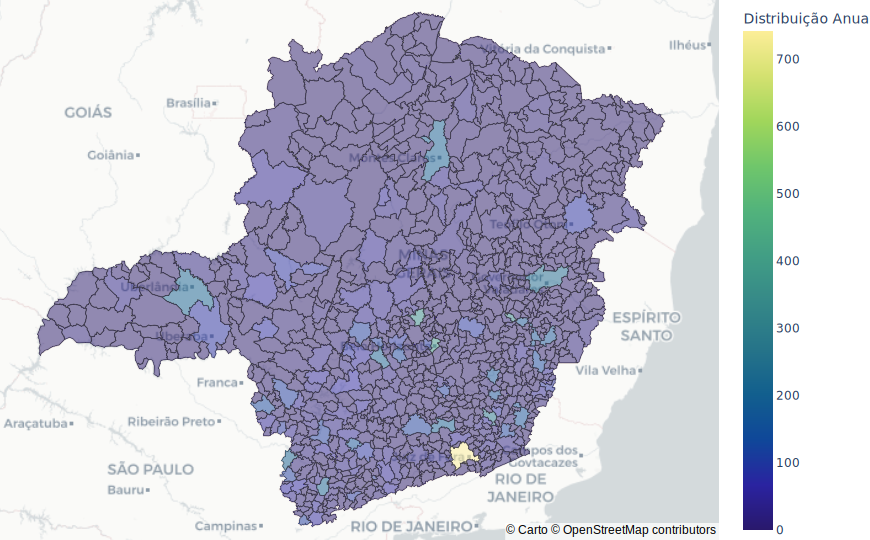

In [117]:
pio.renderers.default = "svg" 
svg_renderer = pio.renderers["svg"]
svg_renderer.width = 870
svg_renderer.height = 540
svg_renderer.engine = 'kaleido'

cols = ['Nome', 'Latitude', 'Longitude', 'DistAnnual']
fig = px.choropleth_mapbox(counties_activity[['Nome', 'DistAnnual']], 
                           geojson=counties_activity[['Nome','DistAnnual', 'geometry']].set_index('Nome').__geo_interface__, 
                           locations='Nome', color='DistAnnual',
                           color_continuous_scale="haline",
                           mapbox_style="carto-positron",
                           zoom=5.3, center = {"lat": -18.644386, "lon": -45.300141},
                           opacity=0.5,
                           labels={'DistAnnual':'Distribuição Anuall'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## Centros de distribuição

In [24]:
distributions_centers = counties_activity[cols].loc[counties_activity.Nome.isin(distributions.DepositoRcbto.unique())]
distributions_centers.drop('DistAnnual', axis=1, inplace=True)
distributions_centers.set_index('Nome', inplace=True)

distributions_geo = pd.merge(distributions[['DepositoRcbto', 'CidadeEntrega']], distributions_centers, 
         left_on='DepositoRcbto', right_index=True)
distributions_geo.rename(columns={'Latitude': 'DepLatitude',
                                  'Longitude': 'DepLongitude'}, inplace=True)
distributions_geo = pd.merge(distributions_geo, counties_activity[cols].drop('DistAnnual', axis=1).set_index('Nome'), 
         left_on='CidadeEntrega', right_index=True)
distributions_geo.rename(columns={'Latitude': 'CELatitude',
                                  'Longitude': 'CELongitude'}, inplace=True)

### Qual centro de distribuição possui mais atividade?

In [25]:
distributions_centers = pd.merge(distributions_centers, distributions.groupby(['DepositoRcbto']).agg({'Rota':'nunique'}), left_index=True, right_index=True)
distributions_centers.rename(columns={'Rota':'QtdEntregas'}, inplace=True)

distributions_centers["QtdEntregasPercent"] = distributions_centers["QtdEntregas"].apply(lambda x:  x/distributions_centers["QtdEntregas"].sum()*100)

- O centro de distribuição de **LAVRAS** é responsável por mais de **50%** das entregas realizadas.
- O centro de distribuição de **UBERLÂNDIA** é o que possui **menor % de entregas**.

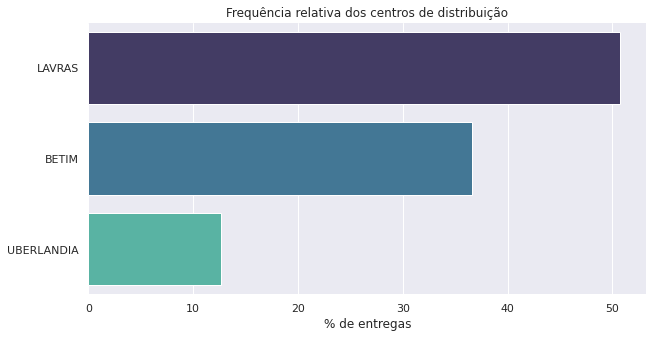

In [26]:
fig, ax = plt.subplots(figsize=(10, 5))

palette = sns.color_palette("mako", n_colors=3)
sns.set_color_codes("muted")

sns.barplot(x="QtdEntregasPercent", y="index", 
            data=distributions_centers.reset_index().sort_values(by='QtdEntregas', ascending=False), 
            palette=palette)
ax.set(ylabel="", xlabel="% de entregas")
ax.set_title('Frequência relativa dos centros de distribuição')
sns.despine(left=True, bottom=True)

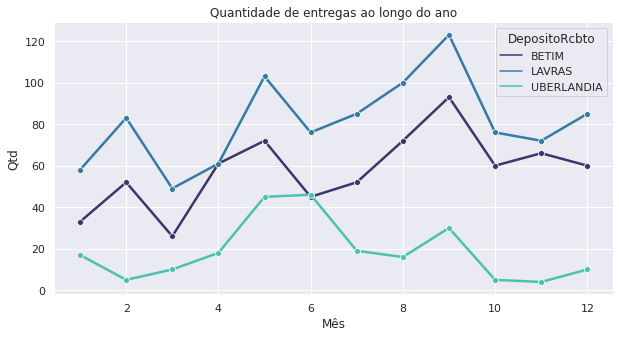

In [27]:
distributions['Mes'] = distributions.DataEmissaoCte.apply(lambda x: x.month)

fig, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(x='Mes', y='Rota',
             hue='DepositoRcbto',
             data=distributions.groupby(['Mes', 'DepositoRcbto']).agg({'Rota': 'nunique'}),
             marker="o", linewidth=2.5, palette=palette)

ax.set(ylabel="Qtd", xlabel="Mês")
ax.set_title('Quantidade de entregas ao longo do ano')
sns.despine(left=True, bottom=True)

### Quantas cidades um centro de distribuição atende? 

- O centro de distribuição de **BETIM** antende em um **raio maior** do que os outros centros.
- O fator que faz com que o CD de **LAVRAS** tenha uma **maior densidade de entregas** do que **BETIM** é que LAVRAS atende cidades mais próximas.

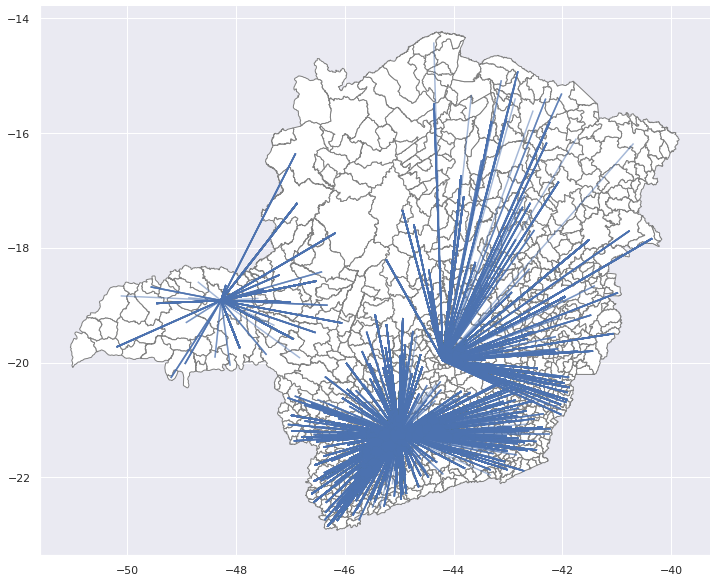

In [28]:
distributions_geo['geometry'] = distributions_geo.apply(lambda x: LineString(get_line(x)), axis=1)

distributions_geo = gpd.GeoDataFrame(distributions_geo, geometry=distributions_geo.geometry)
distributions_geo.crs = county_df.crs


ax = county_df.plot(figsize=(12, 12), color='white', edgecolor='gray')
distributions_geo.plot(ax=ax, alpha=0.5)
sns.despine()

In [29]:
distributions_geo_ = pd.merge(distributions_geo.drop('geometry', axis=1), counties_activity[['Nome', 'geometry']],
                              left_on='CidadeEntrega', right_on='Nome')

O gráfico abaixo mostra mais precisamente como as cidades atendidas por determinado centro de distribuição estão distribuidas ao redor dele.

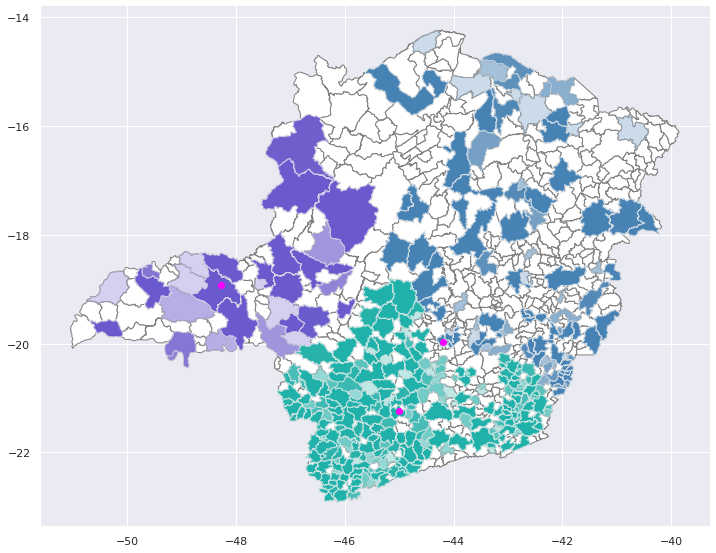

In [30]:
distributions_centers = gpd.GeoDataFrame(distributions_centers, geometry=gpd.points_from_xy(distributions_centers.Longitude,
                                                                    distributions_centers.Latitude))

ax = county_df.plot(figsize=(12, 12), color='white', edgecolor='gray')
distributions_geo_.plot(column='DepositoRcbto', cmap=map_palette, ax=ax, alpha=0.1)
distributions_geo_.plot(column='DepositoRcbto', cmap=map_palette, ax=ax, alpha=0.1)
distributions_geo_.plot(column='DepositoRcbto', cmap=map_palette, ax=ax, alpha=0.1)
distributions_centers.plot(color='magenta', ax=ax)
sns.despine()

In [31]:
distributions_centers = pd.merge(distributions_centers, distributions_geo.groupby('DepositoRcbto').CidadeEntrega.nunique(), 
                             left_index=True, right_index=True)

De fato, o cetro de distribuição de **LAVRAS** é o que atende a maior quantidade de cidades e **é o mais movimentado**.

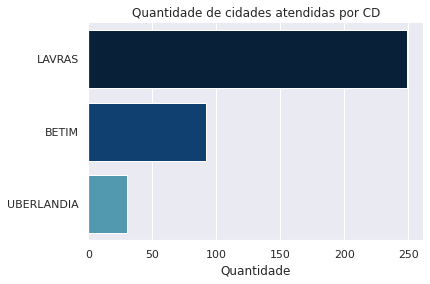

In [32]:
ax = sns.barplot(x='CidadeEntrega', y='index', data=distributions_centers.reset_index().sort_values(
    by='CidadeEntrega', ascending=False), palette='ocean')

ax.set(ylabel='', xlabel='Quantidade', title='Quantidade de cidades atendidas por CD')
sns.despine()

Existem diversas formas de avaliar como as entregas foram feitas no período em questão.
Porém, dada a **limitação imposta** pelos dados fornecidos optamos por partir de **premissas** ao iniciarmos a nossa solução.  

```{admonition} Importante
:class: important
Estamos assumindo que todos os roteiros criados foram os melhores possíveis.
```

A solução abaixo será baseada na **relação entre cidades** com base nos roteiros realizados.

## Roteiros (Importância)

In [33]:
te = TransactionEncoder()
roteiros_arr = distributions.groupby('Rota').agg({'CidadeEntrega': list}).CidadeEntrega.values.tolist()
correlation_data = te.fit(roteiros_arr).transform(roteiros_arr, sparse=True)

correlation_data = pd.DataFrame.sparse.from_spmatrix(correlation_data, columns=te.columns_)
correlation_data.columns = [str(i) for i in correlation_data.columns]

### Qual a frequência das cidades mais encontradas em roteiros?

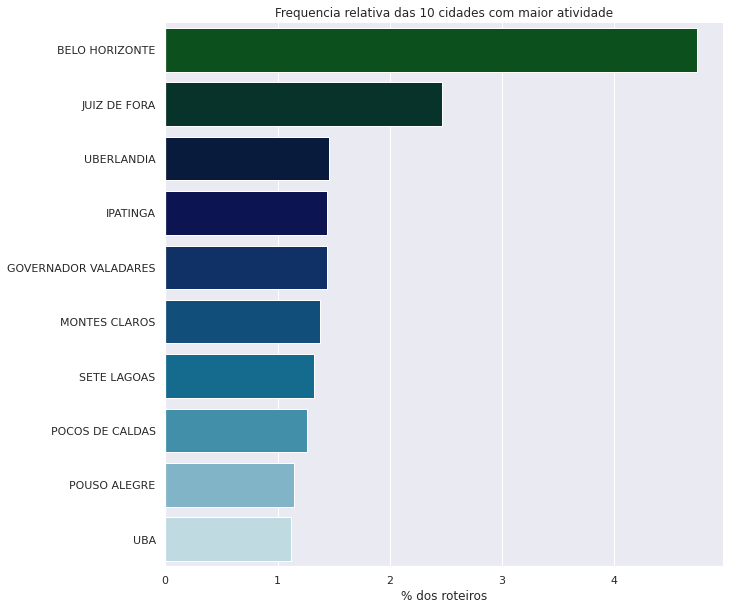

In [34]:
cities_in_routes = correlation_data.sum(axis=0).sort_values(ascending=False)
cities_in_routes = cities_in_routes.reset_index()
cities_in_routes['Percent'] = cities_in_routes[0]/cities_in_routes[0].sum() * 100

fig, ax = plt.subplots(figsize=(10, 10)) 
sns.barplot(x='Percent', y='index', data=cities_in_routes[:10], palette='ocean')
ax.set(ylabel='', xlabel='% dos roteiros', title='Frequencia relativa das 10 cidades com maior atividade')
sns.despine()

### Como as cidades se encontram distribuidas em relação aos roteiros

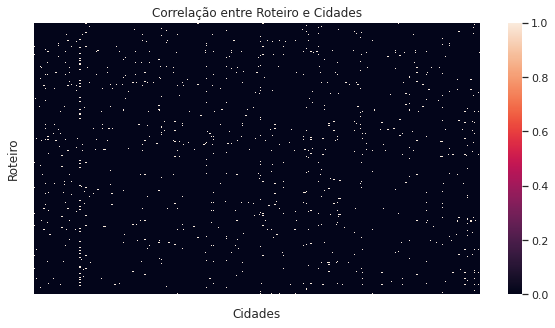

In [35]:
fig, axes = plt.subplots(figsize=(10, 5))

sns.heatmap(correlation_data.values, ax=axes)
axes.set(xlabel='Cidades', ylabel='Roteiro', xticklabels=[], yticklabels=[],
        title='Correlação entre Roteiro e Cidades')
sns.despine(left=True, bottom=True)

In [36]:
def evaluate_support(support_values, corr):
    output = None
    for s in support_values:
        frequents_itemsets = fpgrowth(corr, min_support=s, use_colnames=True)
        len_routes = frequents_itemsets.itemsets.apply(len)
        
        s_routes = frequents_itemsets.support
        df = pd.DataFrame({'Len': len_routes, 'RoutesSupport': s_routes})
        df['Support'] = f'{s*100:.1f}%'
        output = df if output is None else pd.concat([output, df], ignore_index=True)
    return output

test_df = evaluate_support(np.linspace(1e-2, 1e-3, 3), correlation_data)

### Como definir 'importância' em relação a cidades?
- O nosso conceito de 'importância' será baseado em uma estatística descritiva, a **frequência relativa**, em outras palavras: **o quanto uma combinação de cidades ocorreu no período em questão**.
- Para definirmos a importância precisaremos encontrar uma **frequência mínima** de tal forma que, para que uma combinação (de n cidades) possa ser considerada importante ela precisa ocorrer em pelo menos x porcento das entregas.  

```{admonition} Importante
:class: important
Note que não irá existir uma combinação importante de cidades com uma cidade 'não importante'.
```

```{figure} imgs/diagram.png
:name: exemplo-importancia
:align: center

Exemplo hipotético do processo de filtro para até 2 cidades
```

### Qual seria a melhor frequência relativa mínima?


Iremos realizar testes com **3** valores possíveis como **frequência mínima** (1%, 0.5% e 0.1%).  
- Para cada teste realizado a **quantidade de cidades** e a **frequência** nessas combinações serão observadas.
- A **média amostral com um intervalo de confiança de 95%** será usada para descrever esses dados.  
```{admonition} Veja também
:class: seealso
[O que é intervalo de confiança](https://pt.wikipedia.org/wiki/Intervalo_de_confian%C3%A7a)
```


Analisando os resultados:
- **Para frequência mínima igual a 1%**: A maioria das combinações obtidas possuem apenas 1 cidade com uma frequência em torno de 1.75% (uma evidência de que **entregas com destino BELO HORIZONTE está afetando a média de ocorrência de outras cidades**).
- **Para frequência mínima igual a 0.5%**: A quantidade de combinações com mais de 1 cidade aumentou um pouco, e a média de frequência para as combinações abaixou para aproximadamente 1%.
- **Para frequência mínima igual a 0.1%**: Para ambas as médias, a incerteza ao redor das médias estimadas diminuiu. A **quantidade média de cidades por combinação é igual a 4.5**, e a **frequência está abaixo de 0.25%**.

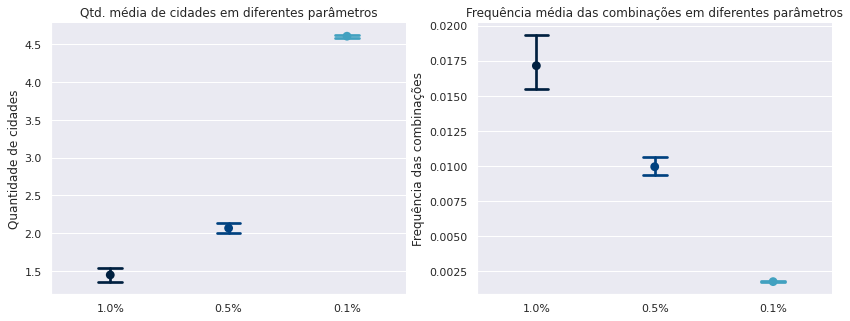

In [37]:
figure = plt.figure(figsize=(14, 5))

axes = figure.add_subplot(1, 2, 1)
sns.pointplot(x='Support', y='Len', data=test_df, capsize=.2, palette="ocean", 
            aspect=.75, kind='point', linestyles='-')
axes.set(xlabel='', ylabel='Quantidade de cidades', title='Qtd. média de cidades em diferentes parâmetros')

axes = figure.add_subplot(1, 2, 2)
sns.pointplot(x='Support', y='RoutesSupport', data=test_df, capsize=.2, palette="ocean", 
            aspect=.75, kind='point', linestyles='-')
axes.set(xlabel='', ylabel='Frequência das combinações', title='Frequência média das combinações em diferentes parâmetros')
sns.despine()

Com base nas analises acima, a melhor **frequência mínima** para se considerar uma combinação ou cidade como 'importante' seria **0.5%**

### Com que frequência as melhores combinações ocorrem?

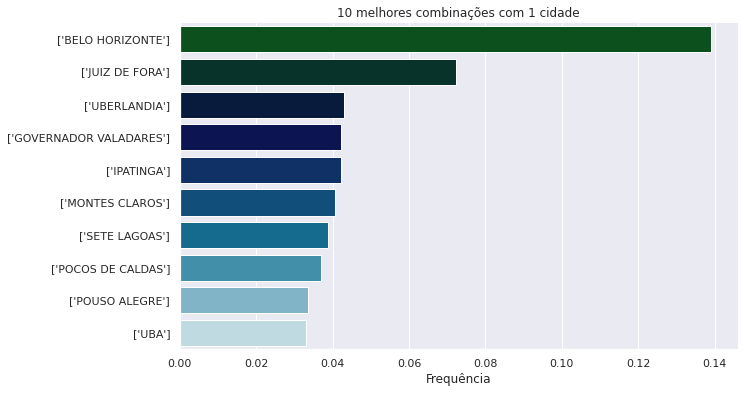

In [38]:
frequents_itemsets = fpgrowth(correlation_data, min_support=MIN_SUPPORT, use_colnames=True)
frequents_itemsets = frequents_itemsets.sort_values(by='support', ascending=False)
frequents_itemsets['itemsets_str'] = frequents_itemsets.itemsets.apply(lambda x: str(list(x)))
frequents_itemsets['Length'] = frequents_itemsets.itemsets.apply(len)

figure = plt.figure(figsize=(10, 6))
ax = sns.barplot(x='support', y='itemsets_str', data=frequents_itemsets[:10], palette='ocean')
ax.set(ylabel='', xlabel='Frequência', title='10 melhores combinações com 1 cidade')
sns.despine()

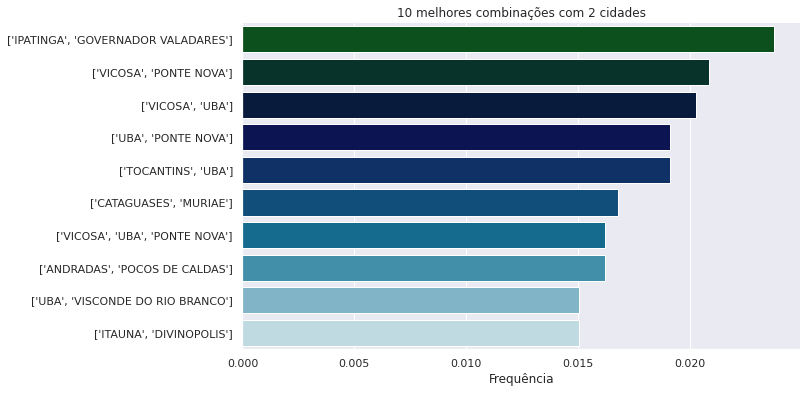

In [39]:
figure = plt.figure(figsize=(10, 6))
ax = sns.barplot(x='support', y='itemsets_str', data=frequents_itemsets.query('Length > 1')[:10], palette='ocean')
ax.set(ylabel='', xlabel='Frequência', title='10 melhores combinações com 2 cidades')
sns.despine()

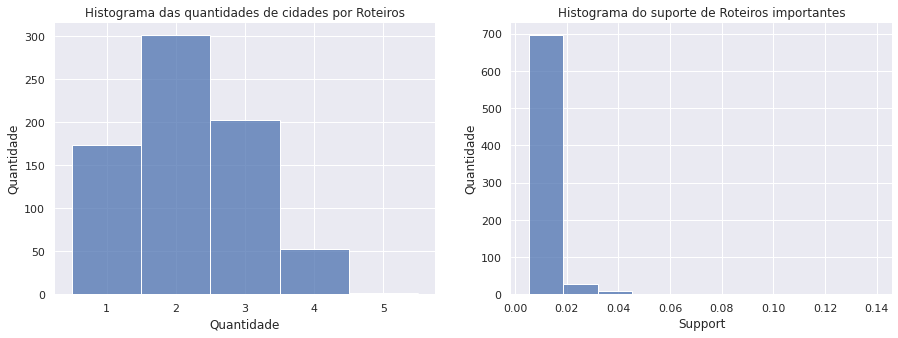

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(x='Length', data=frequents_itemsets, ax=axes[0], palette='ocean', discrete=True)
sns.histplot(x='support', data=frequents_itemsets, ax=axes[1], bins=10, palette='ocean')

axes[0].set(xlabel='Quantidade', ylabel='Quantidade', title='Histograma das quantidades de cidades por Roteiros')
axes[1].set(xlabel='Support', ylabel='Quantidade', title='Histograma do suporte de Roteiros importantes')

sns.despine(left=True, bottom=True)

### Como encontrar relações entre cidades se baseando nos roteiros criados?

Com base nas combinações de cidades consideradas importantes iremos estabelecer uma **correlação entre cidades**, para essa correlação iremos mensurar a **força dessa correlação** e a **chance dessa correlação ser apenas um acaso**.
- Em outras palavras, cidades que possuem uma **correlação alta** são encontradas com **mais frequência nos roteiros**.
- Para **mensurar a força de uma correlação** (o quão verdadeira ela é) iremos usar uma métrica chamada **Confiança**.
- Uma **Confiança** forte não significa que essa correlação não possa ser um **acaso**, para identificarmos correlações que são frutos do **acaso** iremos usar uma métrica chamada **Lift**.
- A métrica **Confiança** é baseada em **probabilidade condicionada**.  

```{admonition} Veja também
:class: seealso
[O que é probabilidade condicionada](https://pt.wikipedia.org/wiki/Probabilidade_condicionada)
```

Exemplo:

```{figure} imgs/relation.png
:name: exemplo-importancia
:align: center

Exemplo hipotético do processo de filtro para até 2 cidades e um diagrama de venn da probabilidade condicionada 
```

Essa relação pode ser interpretada como: 
- **80%** das vezes em que **BELO HORIZONTE e CONTAGEM** apareceram em um roteiro, **BETIM** estava com eles.
- Ou, a probabilidade de **BETIM** aparecer em um roteiro, dado que **BELO HORIZONTE e CONTAGEM** estão nesse roteiro é igual a **80%**.

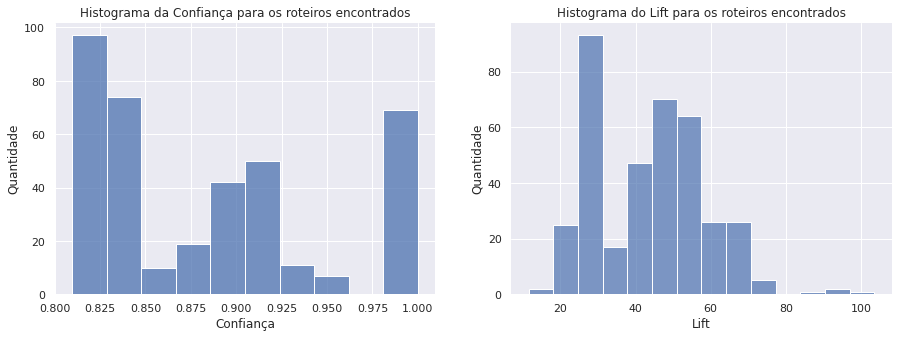

In [41]:
rules = association_rules(frequents_itemsets, metric='confidence', min_threshold=MIN_CONFIDENCE)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(x='confidence', data=rules, palette=sns.color_palette('ocean'), ax=axes[0])
sns.histplot(x='lift', data=rules, palette='ocean', ax=axes[1], alpha=.7)

axes[0].set(xlabel='Confiança', ylabel='Quantidade', title='Histograma da Confiança para os roteiros encontrados')
axes[1].set(xlabel='Lift', ylabel='Quantidade', title='Histograma do Lift para os roteiros encontrados')
sns.despine(left=True, bottom=True)

In [42]:
test = 0
conclusion = {'Nome':[], 'Result':[]} 
for idx, row in rules.iterrows():
    ant = list(row['antecedents'])
    con = list(row['consequents'])
    cd = distributions.loc[distributions.CidadeEntrega.isin(ant)]
    cd = cd.DepositoRcbto.mode()[0]
    for countie in ant+con:
        conclusion.get('Nome', []).append(countie)
        conclusion.get('Result', []).append(cd)
conclusion = pd.DataFrame(conclusion).drop_duplicates()
conclusion.set_index('Nome', inplace=True)

Baseando-se nas correlaçoes encontradas entre cidades, iremos **inferir** se as cidades consideradas importantes **estão sendo atendidas pelos melhores centros de distribuição**.

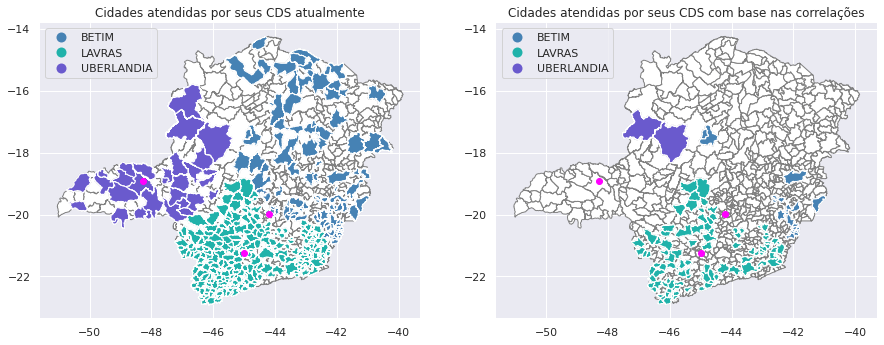

In [43]:
conclusion_geo = pd.merge(counties_activity.set_index('Nome'), conclusion, on='Nome')

fig, axes = plt.subplots(1, 2, figsize=(15, 8))

county_df.plot(color='white', edgecolor='gray', ax=axes[0])
distributions_geo_.plot(column='DepositoRcbto', legend=True, legend_kwds={'loc':'upper left'}, cmap=map_palette, ax=axes[0])
distributions_geo_.plot(column='DepositoRcbto', legend=True, legend_kwds={'loc':'upper left'}, cmap=map_palette, ax=axes[0])
distributions_geo_.plot(column='DepositoRcbto', legend=True, legend_kwds={'loc':'upper left'}, cmap=map_palette, ax=axes[0])
distributions_centers.plot(color='magenta', ax=axes[0])

county_df.plot(color='white', edgecolor='gray', ax=axes[1])
conclusion_geo.plot(column='Result', legend=True, legend_kwds={'loc':'upper left'}, cmap=map_palette, ax=axes[1])
conclusion_geo.plot(column='Result', legend=True, legend_kwds={'loc':'upper left'}, cmap=map_palette, ax=axes[1])
conclusion_geo.plot(column='Result', legend=True, legend_kwds={'loc':'upper left'}, cmap=map_palette, ax=axes[1])
distributions_centers.plot(color='magenta', ax=axes[1])

axes[0].set(title='Cidades atendidas por seus CDS atualmente')
axes[1].set(title='Cidades atendidas por seus CDS com base nas correlações')
sns.despine(left=True, bottom=True)

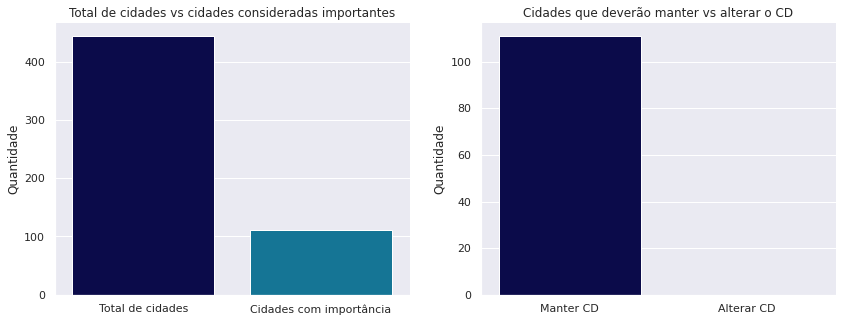

In [44]:
conclusion = pd.merge(conclusion.reset_index(), distributions[['CidadeEntrega', 'DepositoRcbto']].drop_duplicates(), 
                      left_on='Nome', right_on='CidadeEntrega', how='left').drop('CidadeEntrega', axis=1)
conclusion.set_index('Nome', inplace=True)
conclusion['Change'] = conclusion.Result != conclusion.DepositoRcbto

important_cities = conclusion.index.nunique()
keep_counties = conclusion.loc[conclusion.Change==False].index.nunique()
change_counties = conclusion.loc[conclusion.Change==True].index.nunique()

figure = plt.figure(figsize=(14, 5))

ax = figure.add_subplot(1, 2, 1)
sns.barplot(y=[444, important_cities], x=['Total de cidades', 'Cidades com importância'], palette='ocean')
ax.set(ylabel='Quantidade', title='Total de cidades vs cidades consideradas importantes')

ax = figure.add_subplot(1, 2, 2)
sns.barplot(y=[keep_counties, change_counties], x=['Manter CD', 'Alterar CD'], palette='ocean')
ax.set(ylabel='Quantidade', title='Cidades que deverão manter vs alterar o CD')
sns.despine()

In [45]:
def get_coordinates(counties):
    output = []
    for c in counties:
        info = counties_activity.loc[counties_activity.Nome==c]
        output.append([info['Latitude'], info['Longitude']])
    return output

def is_important(route):
    return any([np.isin(x, conclusion.index) for x in route]) 

## Roteiros

```{figure} imgs/vrp.png
:name: roteirização de veículos 
:align: center
```

Com os roteiros relevantes filtrados, a próxima etapa será avaliá-los. Para fazer isso iremos ordenar as cidades de um roteiro de tal forma que a **distância percorrida** seja a menor possível, esse tipo de problema (ajuste de roteiros) é abordado em um campo chamado **VRP** (Problemas de roteirização de veículos).

**VRP:** É uma classe de problemas que envolve encontrar um formato ideal de rotas que serão trafegadas por uma frota de veículos para servir um conjunto de clientes.
Dentre as características encontradas nesse conjunto de problemas podemos listar:
- Atribuir a rota mais curta a um veículo de tal forma que a quantidade de entregas (unidades) satisfaçam as suas **limitações de capacidade**;
- Encontrar um conjunto de rotas com **menor custo** de viagem total e maior satisfação do cliente (chegando ao local no **tempo correto**).

```{admonition} Importante
:class: important
Por conta das limitações impostas nos dados não conseguimos fazer uma abordagem completa levando em consideração todas as características de um VRP.
```

Iremos utilizar como comparação os **roteiros já formados** que satisfazem a condição de importância (definida acima) com uma **versão otimizada (ordenada de tal forma que a distância total percorrida seja a menor)** do mesmo roteiro (que passa pelas mesmas cidades de entrega).  
Para a criação desses roteiros otimizados iremos fazer as seguintes premissas:
- O caminhão não pode passar duas vezes pela mesma cidade no percurso;
- O caminhão precisa realizar as entregas e voltar ao ponto de partida.  

Por meio desses dados iremos calcular a **distância total percorrida** e o **ponto de partida ideal** (considerando os 4 centros de distribuição disponíveis), a distância total percorrida será usada para comparar os roteiros atuais com os roteiros otimizados.

```{admonition} Nota
:class: note
Iremos avaliar 1018 roteiros que satisfazem a condição de importância.
```

In [46]:
routes = distributions.sort_values(['Rota', 'PesoTransp'], ascending=False)
routes = routes.groupby('Rota').agg({'CidadeEntrega': list, 'PesoTransp': sum, 'DistPercorrida': 'mean', 'DepositoRcbto': pd.Series.mode})

routes['CidadeEntrega'] = routes.CidadeEntrega.apply(pd.unique)
routes['Coordenadas'] = routes.CidadeEntrega.apply(get_coordinates)
routes['Coordenadas'] = routes['Coordenadas'].apply(np.squeeze)
routes.rename(columns={'CidadeEntrega':'Roteiro', 'DistPercorrida':'DistanciaRoteiro', 'DepositoRcbto':'Origem'}, inplace=True)
routes['Importante'] = routes.Roteiro.apply(is_important)
important_routes = routes.loc[routes.Importante]

In [47]:
def replace(old_str, i):
    return old_str[:i] + "," + old_str[i+1:]

distances_df = pd.read_csv('data/distance_matrix_data.csv')

distances_temp_ = distances_df[distances_df.Rota!=999].copy()
distances_temp_['CoordenadasOrigem'] = distances_temp_.CoordenadasOrigem.apply(lambda x: replace(x, 8))
distances_temp_['CoordenadasDestino'] = distances_temp_.CoordenadasDestino.apply(lambda x: replace(x, 8))

distances_df = distances_temp_.append(distances_df[distances_df.Rota==999])
distances_df['CoordenadasOrigem'] = distances_df['CoordenadasOrigem'].apply(ast.literal_eval)
distances_df['CoordenadasDestino'] = distances_df['CoordenadasDestino'].apply(ast.literal_eval)

distances_df['CoordenadasOrigem'] = distances_df['CoordenadasOrigem'].apply(lambda x: pd.to_numeric(x))
distances_df['CoordenadasDestino'] = distances_df['CoordenadasDestino'].apply(lambda x: pd.to_numeric(x))

In [48]:
# Todos onde a origem é um Centro de distribuição
# Todos onde a origem é diferente do destino

def get_distributions_centers():
    lats = distributions_centers['Latitude']
    long = distributions_centers['Longitude']
    coordinates = list(zip(lats, long))
    names = distributions_centers.index.values.tolist()

    diadema_coordinates = county_df_total.loc[county_df_total.NOME == 'Diadema'][['LATITUDE', 'LONGITUDE']]
    diadema_coordinates = list(diadema_coordinates.values.tolist()[0])
    coordinates.append(diadema_coordinates)
    names.append('DIADEMA')
    return names, coordinates

distances_deliveries_df = distances_df.loc[distances_df.Origem.isin(get_distributions_centers()[0])]
distances_deliveries_df = distances_deliveries_df.loc[distances_deliveries_df.Rota!=999]

to_drop = distances_deliveries_df.loc[(distances_deliveries_df.Destino.isin(get_distributions_centers()[0])) | 
                                      (distances_deliveries_df.Origem==distances_deliveries_df.Destino)].index
distances_deliveries_df = distances_deliveries_df.drop(to_drop, axis=0)
distances_deliveries_df = distances_deliveries_df.drop_duplicates(subset=['Rota', 'Origem', 'Destino'])

In [49]:
distances_deliveries_df = pd.merge(distances_deliveries_df.groupby(['Rota', 'Origem']).agg({'Destino':list, 'CoordenadasDestino':list}).reset_index(),
                                   distances_deliveries_df[['Origem', 'CoordenadasOrigem']].drop_duplicates(subset='Origem'), on='Origem', how='left')

In [50]:
def optmize_route(x):
    origem = x['Origem']
    destinos = x['Destino']
    l = [origem] + destinos
    
    coord_origem = x['CoordenadasOrigem']
    coord_destinos = x['CoordenadasDestino']
    l_coord = [coord_origem] + coord_destinos
    
    it = 10
    solutions = [hill_climbing(np.array(l_coord)) for _ in range(it)]
    distances = list(map(lambda x: x[0], solutions))
    _, solution = solutions[np.argmin(distances)]
    
    solution = solution[solution.index(0):] + solution[:-len(solution)+solution.index(0)]
    solution = solution[1:]
    return np.take(np.array(l), solution)    

distances_deliveries_df['MelhorRoteiro'] = distances_deliveries_df.apply(optmize_route, axis=1)

In [51]:
# Busca pelas distancias no conjunto total
def filter_by_origin_destination(origin, destination):
    return distances_df.loc[(distances_df.Origem==origin) & 
                            (distances_df.Destino==destination)].iloc[0]

def distance_from_route(origin, destinations):
    distance, duration = filter_by_origin_destination(origin, destinations[0])[['Distancia', 'Duracao']].values.tolist()
    for idx, dest in enumerate(destinations[:-1]):
        dist, dur = filter_by_origin_destination(destinations[idx+1], dest)[['Distancia', 'Duracao']].values.tolist()
        distance += dist
        duration += dur
    dist, dur = filter_by_origin_destination(destinations[-1], origin)[['Distancia', 'Duracao']].values.tolist()
    distance += dist
    duration += dur
    return distance, duration

def measure_distance(x):
    origin =  x['Origem']
    best_destinations = x['MelhorRoteiro']
    distance, duration = distance_from_route(origin, best_destinations)
    return distance, duration

distances_deliveries_df['DistanciaMelhorRoteiro'], distances_deliveries_df['DuracaoMelhorRoteiro'] = zip(
    *distances_deliveries_df.reset_index().apply(measure_distance, axis=1))

In [52]:
best_origins = distances_deliveries_df.groupby(['Rota']).apply(lambda x: x[['Origem', 'DistanciaMelhorRoteiro']].set_index('Origem').DistanciaMelhorRoteiro.idxmin())
distances_deliveries_df = pd.merge(distances_deliveries_df, best_origins.reset_index(),
                                   on='Rota')
distances_deliveries_df.drop(['Destino', 'CoordenadasDestino', 'CoordenadasOrigem'], axis=1, inplace=True)
# DistanciaMediaOrigem
distances_deliveries_df.columns = ['Rota', 'Origem', 'MelhorRoteiro', 'DistanciaMelhorRoteiro', 'DuracaoRoteiro', 'MelhorOrigem']

In [53]:
important_routes = pd.merge(important_routes.drop(['Coordenadas', 'Importante'], axis=1), 
                            distances_deliveries_df.loc[distances_deliveries_df.Origem==distances_deliveries_df.MelhorOrigem].drop('Origem', axis=1), 
                            left_index=True, right_on='Rota', how='left').set_index('Rota')

In [54]:
important_routes['VariacaoDistanciaRoteiros'] = important_routes.DistanciaRoteiro-important_routes.DistanciaMelhorRoteiro
important_routes['VariacaoPositiva'] = important_routes.VariacaoDistanciaRoteiros.apply(lambda x: x>=0)

### Como os roteiros feitos em 2020 se diferem em termos de distância percorrida dos roteiros otimizados?

Podemos ver que existe uma diferença entre ambas as distâncias, em relação a distância percorrida dos roteiros a sua média é puxada para a direita por uns poucos roteiros com distância total **exageradamente alta**. Iremos considerar isso mais abaixo quando escolhermos a mediana para representar o centro dessa variável.
- Houve uma **redução na distância percorrida** dos roteiros otimizados em comparação com os roteiros atuais (a sua média é de **601 Km** e as distâncias estão mais próximas da média com um desvio padrão de **237 Km**)
- Um roteiro deve ter entre **236-1326 Km**, já um roteiro otimizado deve ter entre **364-838 Km** 

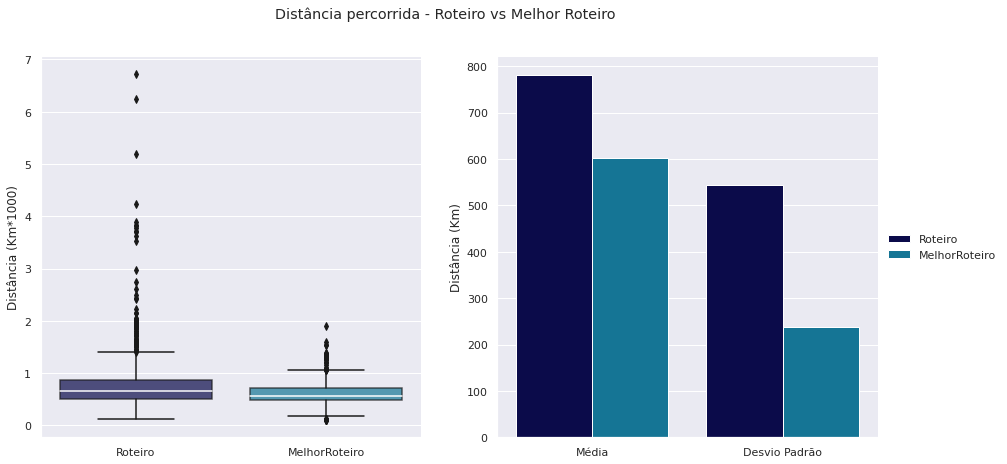

In [55]:
distance_routes_stats = important_routes.DistanciaMelhorRoteiro.describe()[['mean', 'std']].to_frame()
distance_routes_stats = distance_routes_stats.rename(columns={'DistanciaMelhorRoteiro': 'Valor'}).reset_index()
distance_routes_stats['Variavel'] = 'MelhorRoteiro'

temp_ = important_routes.DistanciaRoteiro.describe()[['mean', 'std']].to_frame()
temp_ = temp_.rename(columns={'DistanciaRoteiro': 'Valor'}).reset_index()
temp_['Variavel'] = 'Roteiro'

distance_routes_stats = distance_routes_stats.append(temp_).rename(columns={'index': 'Estatistica'})
distance_routes_stats['Estatistica'] = distance_routes_stats.Estatistica.apply(lambda x: 'Média' if x=='mean' else 'Desvio Padrão')
distance_routes_stats['Valor'] = distance_routes_stats.Valor.apply(lambda x: x/1000)

distance_values = pd.DataFrame({'Value':important_routes.DistanciaRoteiro, 'Variavel':['Roteiro']*1018})
distance_values = distance_values.append(pd.DataFrame({'Value':important_routes.DistanciaMelhorRoteiro, 'Variavel':['MelhorRoteiro']*1018}))

fig = plt.figure(figsize = (15, 7))
fig.suptitle('Distância percorrida - Roteiro vs Melhor Roteiro')

fig.add_subplot(1, 2, 1)
sns.set_color_codes("pastel")
ax = sns.boxplot(x='Variavel', y='Value', data=distance_values.reset_index(), palette='ocean',
                 medianprops=dict(color="white"), boxprops=dict(alpha=.7))
ax.set(xlabel='', ylabel='Distância (Km*1000)', title='')
ax.yaxis.get_offset_text().set_visible(False)

fig.add_subplot(1, 2, 2)
ax = sns.barplot(x='Estatistica', y='Valor', hue='Variavel', data=distance_routes_stats.sort_values(by='Variavel', ascending=False), palette='ocean')
ax.set(xlabel='', ylabel='Distância (Km)', title='')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

sns.despine()

### Qual seria a diferença percentual na quilometragem total em 2020 se os roteiros fossem trocados pelos roteiros otimizados?

Se substituíssemos os roteiros atuais pelos roteiros otimizados haveria uma **redução** na quilometragem total em 2020 de **22,9%**. 
- Com os roteiros atuais foram percorridos aproximadamente **795,42 mil Km**, já com os roteiros otimizados esse valor cairia para **612,72 mil Km**
- Em relação ao centros de distribuição **Betim**, **Lavras** e **Uberlândia** essas diferenças percentuais seriam respectivamente **9,2%**, **28,1%** e **6,7%**

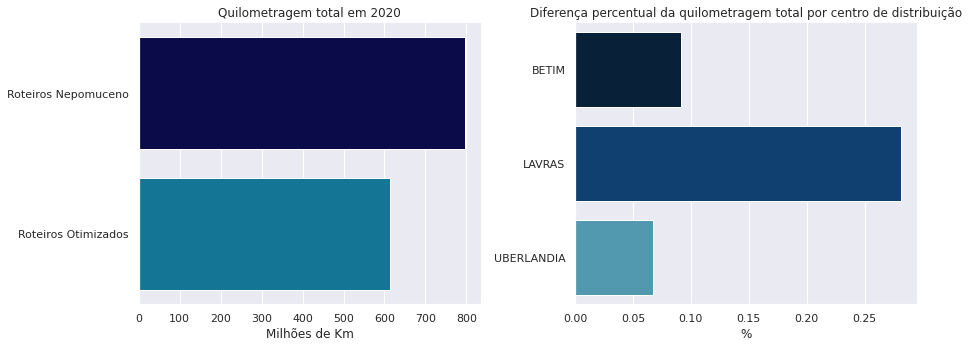

In [56]:
total_mileage = important_routes.DistanciaRoteiro.sum()
total_mileage_new_routes = important_routes.DistanciaMelhorRoteiro.sum()
total_mileage_diff = (total_mileage-total_mileage_new_routes)
total_mileage_percent_change = total_mileage_diff/total_mileage


mileage_by_cds = important_routes[['Origem', 'DistanciaRoteiro', 'DistanciaMelhorRoteiro']].groupby('Origem').sum()
mileage_by_cds = mileage_by_cds.transform(lambda x: x/1e7)
mileage_by_cds = mileage_by_cds.assign(DiffPercentual=(
    mileage_by_cds.DistanciaRoteiro-mileage_by_cds.DistanciaMelhorRoteiro)/mileage_by_cds.DistanciaRoteiro)
mileage_by_cds = mileage_by_cds.drop(columns=['DistanciaRoteiro', 'DistanciaMelhorRoteiro'])                             
mileage_by_cds.columns = ['Diff Percentual']

mileage_by_cds = mileage_by_cds.reset_index()

fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
sns.barplot(y=['Roteiros Nepomuceno', 'Roteiros Otimizados'], x=[total_mileage/1e6, total_mileage_new_routes/1e6], palette='ocean', ax=ax)
ax.set(title='Quilometragem total em 2020', xlabel='Milhões de Km')


ax = fig.add_subplot(1, 2, 2)
sns.barplot(x='Diff Percentual', y='Origem', data=mileage_by_cds, palette='ocean', ax=ax)
ax.set(title='Diferença percentual da quilometragem total por centro de distribuição', xlabel='%', ylabel='')

plt.tight_layout()

sns.despine()

### Qual seria a diferença percentual na distância mediana por roteiro se eles fossem trocados pelos roteiros otimizados?

A **distância mediana por roteiro** também seria afetada se trocássemos pelos roteiros otimizados, com uma redução de **8,7%**.
- Para o centro de distribuição de Uberlândia haveria um aumento de **5%**, isso se deve ao fato de que não foi possível encontrar roteiros melhores para a maioria dos roteiros com essa origem

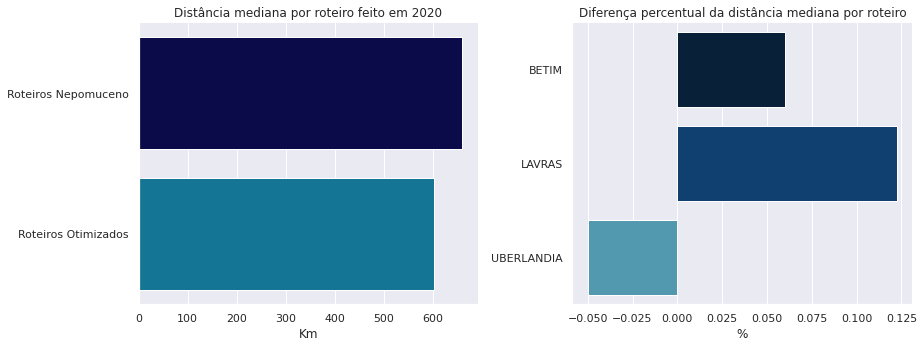

In [57]:
median_routes_distance = important_routes.DistanciaRoteiro.median()
mean_routes_distance_new_routes = important_routes.DistanciaMelhorRoteiro.mean()
median_routes_diff = (median_routes_distance-mean_routes_distance_new_routes)
median_distance_percent_change = median_routes_diff/median_routes_distance

median_distance_by_cds = important_routes[['Origem', 'DistanciaRoteiro', 'DistanciaMelhorRoteiro']].groupby(
    'Origem').agg({'DistanciaRoteiro': 'median', 'DistanciaMelhorRoteiro': 'mean'})
median_distance_by_cds = median_distance_by_cds.transform(lambda x: x/1e7)
median_distance_by_cds = median_distance_by_cds.assign(DiffPercentual=(
    median_distance_by_cds.DistanciaRoteiro-median_distance_by_cds.DistanciaMelhorRoteiro)/median_distance_by_cds.DistanciaRoteiro)
median_distance_by_cds = median_distance_by_cds.drop(columns=['DistanciaRoteiro', 'DistanciaMelhorRoteiro'])                             
median_distance_by_cds.columns = ['Diff Percentual']

median_distance_by_cds = median_distance_by_cds.reset_index()

fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
sns.barplot(y=['Roteiros Nepomuceno', 'Roteiros Otimizados'], x=[median_routes_distance/1e3, mean_routes_distance_new_routes/1e3], palette='ocean', ax=ax)
ax.set(title='Distância mediana por roteiro feito em 2020', xlabel='Km')

ax = fig.add_subplot(1, 2, 2)
sns.barplot(x='Diff Percentual', y='Origem', data=median_distance_by_cds, palette='ocean', ax=ax)
ax.set(title='Diferença percentual da distância mediana por roteiro', xlabel='%', ylabel='')

plt.tight_layout()
sns.despine()

### Dos roteiros realizados quantos poderiam ter uma origem diferente?

- Foram encontrados **261** roteiros onde uma origem diferente produziria uma redução na distância total do percurso. A maioria deles partem de Lavras e um apenas de Uberlândia e Betim.
- Para **216** roteiros que partem de **Lavras** foi recomendado **Betim** e para **43** roteiros foi recomendado **Diadema**
- Para um único roteiro que parte de **Uberlândia** foi recomendado **Betim**
- E para um único roteiro que parte de **Betim** foi recomendado **Lavras**

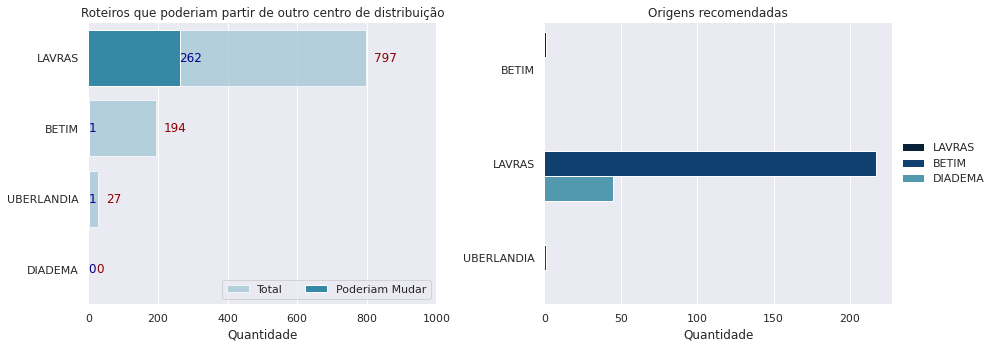

In [58]:
origin_info = important_routes.Origem.value_counts().to_frame().reset_index().rename(columns={'Origem':'Total'})
origin_info = pd.merge(origin_info, important_routes.loc[important_routes.MelhorOrigem!=important_routes.Origem].Origem.value_counts().to_frame().reset_index(), on='index', how='outer')
origin_info = origin_info.rename(columns={'Origem':'Change'})
origin_info = origin_info.fillna(0)
origin_info = origin_info.append(pd.DataFrame({'index': ['DIADEMA'], 'Total': [0.0], 'Change':[0.0]}))
origin_info = origin_info.sort_values(by='Change', ascending=False)


bestorigim_info = important_routes[important_routes.Origem!=important_routes.MelhorOrigem].groupby('Origem').MelhorOrigem.apply(pd.value_counts).to_frame().reset_index()

f, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.set_color_codes("pastel")
sns.barplot(x='Total', y='index', data=origin_info, label='Total', 
            color=sns.color_palette('ocean').as_hex()[-1], ax=ax[0], alpha=.7)

sns.set_color_codes("muted")
sns.barplot(x='Change', y='index', data=origin_info, label='Poderiam Mudar',
            color=sns.color_palette('ocean').as_hex()[4], ax=ax[0])

ax[0].legend(ncol=2, loc="lower right", frameon=True)
ax[0].set(xlim=(0, 1000), ylabel="", xlabel="Quantidade",
       title="Roteiros que poderiam partir de outro centro de distribuição")

ax[0].bar_label(ax[0].containers[1], color='darkblue')
ax[0].bar_label(ax[0].containers[0], padding=8, color='darkred')

sns.barplot(x='MelhorOrigem', y='Origem', hue='level_1', data=bestorigim_info, ax=ax[1], palette='ocean')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
ax[1].set(ylabel="", xlabel="Quantidade", title="Origens recomendadas")

plt.tight_layout()
sns.despine(left=True, bottom=True)

```{admonition} Atenção
:class: warning
Foram encontrados 9 roteiros onde uma sugestão de origem diferente foi feita mas a distância total do percurso é maior no roteiro otimizado, eles serão ignorados mas não serão removidos.
A Rota desses roteiros são: 44351, 46335, 50770, 52376, 54451, 55439, 60696, 61417, 63307
```

### Como as cidades importantes ficam distribuidas em relação ao Centro de distribuição se trocarmos a origem?

In [59]:
conclusion_by_routes = important_routes.explode('Roteiro')[['Roteiro', 'Origem', 'MelhorOrigem']].groupby('Roteiro').agg({'Origem':pd.Series.mode, 'MelhorOrigem':pd.Series.mode})
conclusion_by_routes['MelhorOrigem'] = conclusion_by_routes.MelhorOrigem.apply(lambda x: x if not isinstance(x, np.ndarray) else x[0])
conclusion_by_routes['Fator'] = 'Roteiros'
conclusion_by_routes = conclusion_by_routes.reset_index()
conclusion_by_routes.rename(columns={'Roteiro': 'Nome', 'MelhorOrigem': 'MelhorCD', 'Origem': 'CDAtual'}, inplace=True)

# Drop cds counties
to_drop = conclusion_by_routes[(conclusion_by_routes.Nome.isin(get_distributions_centers()[0]))].index
conclusion_by_routes = conclusion_by_routes.drop(to_drop, axis=0)

Agora podemos redistribuir as cidades com base no centro de distribuição recomendado, usaremos a moda do centro de distribuição recomendado para cada cidade nos roteiros analisados.  
Analisando os mapas conseguimos ver que:
- Algumas cidades ao sul de Minas Gerais deveriam ser atendidas pelo Centro de Distribuição de Diadema
- Algumas cidades na região metropolitana de Belo Horizonte deveriam ser atendidas pelo centro de distribuição de Betim 

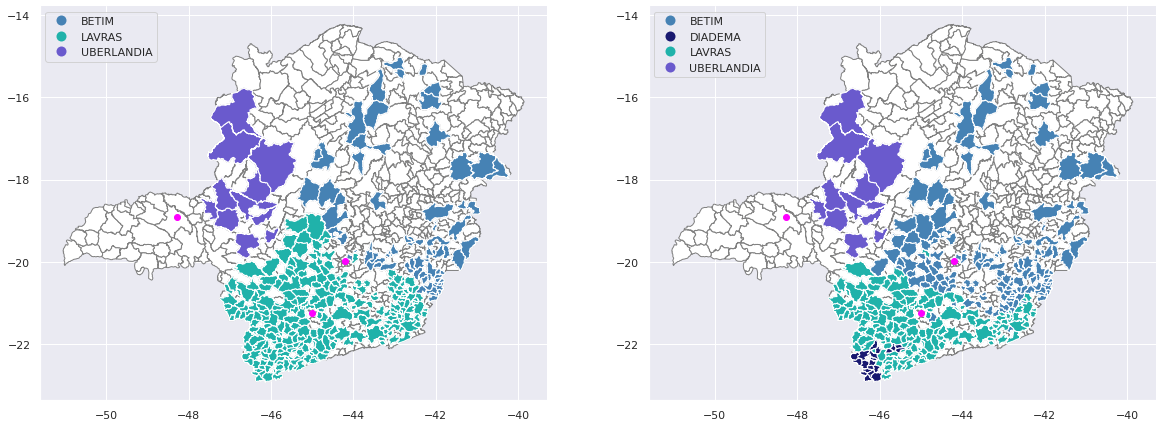

In [60]:
conclusion_geo = pd.merge(counties_activity.set_index('Nome'), conclusion_by_routes, on='Nome')

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

county_df.plot(color='white', edgecolor='gray', ax=axes[0])
conclusion_geo.plot(column='CDAtual', legend=True, legend_kwds={'loc':'upper left'}, cmap=map_palette, ax=axes[0])
conclusion_geo.plot(column='CDAtual', legend=True, legend_kwds={'loc':'upper left'}, cmap=map_palette, ax=axes[0])
conclusion_geo.plot(column='CDAtual', legend=True, legend_kwds={'loc':'upper left'}, cmap=map_palette, ax=axes[0])
distributions_centers.plot(color='magenta', ax=axes[0])

county_df.plot(color='white', edgecolor='gray', ax=axes[1])
conclusion_geo.plot(column='MelhorCD', legend=True,
                    legend_kwds={'loc':'upper left'}, ax=axes[1], cmap=map_palette)
conclusion_geo.plot(column='MelhorCD', legend=True,
                    legend_kwds={'loc':'upper left'}, ax=axes[1], cmap=map_palette)
conclusion_geo.plot(column='MelhorCD', legend=True, 
                    legend_kwds={'loc':'upper left'}, ax=axes[1], cmap=map_palette)
conclusion_geo.plot(column='MelhorCD', legend=True, 
                    legend_kwds={'loc':'upper left'}, ax=axes[1], cmap=map_palette)

distributions_centers.plot(color='magenta', ax=axes[1])
sns.despine()

In [67]:
best_origin_by_distance = distances_df[(distances_df.Origem!=distances_df.Destino) & (distances_df.Rota==999) & (~distances_df.Origem.isin(get_distributions_centers()[0]))]
best_origin_by_distance = best_origin_by_distance.groupby('Origem').apply(lambda x: x[['Destino', 'Distancia']].set_index('Destino').Distancia.idxmin()).to_frame()
best_origin_by_distance = best_origin_by_distance.reset_index()
best_origin_by_distance.columns = ['Nome', 'MelhorCD']

In [89]:
best_origin_cds = pd.DataFrame({'Nome': get_distributions_centers()[0],
                                'CDAtual': get_distributions_centers()[0],
                                'MelhorCD': get_distributions_centers()[0]})

conclusion_by_distance = distributions_geo_[['Nome', 'DepositoRcbto', 'geometry']]
conclusion_by_distance = conclusion_by_distance[(~conclusion_by_distance.Nome.isin(conclusion_by_routes.Nome))]
conclusion_by_distance = conclusion_by_distance.drop_duplicates(subset=['Nome'])
conclusion_by_distance = conclusion_by_distance[conclusion_by_distance.Nome!='UBERLANDIA']
conclusion_by_distance = pd.merge(conclusion_by_distance, best_origin_by_distance, on='Nome')
conclusion_by_distance = conclusion_by_distance.rename(columns={'DepositoRcbto': 'CDAtual'})
conclusion_by_distance = conclusion_by_distance.append(best_origin_cds)

conclusion_by_distance['Fator'] = 'Distância'
conclusion = conclusion_by_routes.append(conclusion_by_distance.drop('geometry', axis=1))
conclusion.to_csv('resultado_avaliacao.csv', index=False)

In [104]:
manual_adjust = {'ARGIRITA': 'LAVRAS', 'CONCEICAO DO PARA': 'BETIM', 
                 'CORONEL XAVIER CHAVES': 'LAVRAS', 'ITUTINGA': 'LAVRAS', 
                 'SENADOR JOSE BENTO': 'DIADEMA'}
for i in manual_adjust:
    conclusion.loc[conclusion.loc[conclusion.Nome==i].index, 'MelhorCD'] = manual_adjust[i]

# Conclusão

Foram feitas análises nos dados na tentativa de avaliar os roteiros criados pela Nepomuceno em 2020 (Estão os roteiros estruturados bons? O que signfica um roteiro ser bom? As cidades atendidas atualmente estão sendo atendidas pelo centro de distribuição ideal? E como distribuir as cidades entre os centros de distruição considerando os roteiros que foram montados anteriormente?).

Com essa análise, conseguimos:
- Entender como as entregas estão distribuidas nas cidades atendidas;
- Definir um conceito de 'importância', para que conseguissemos filtrar os roteiros/cidades que possuem **maior relevância**;
- Encontrar **correlações entre cidades** e mensurar a força dessa correlação com base nos roteiros;
- Encontrar roteiros que possam ser otimizados levando em consideração a distância percorrida;
- Recomendar qual o **melhor centro de distribuição** para atender uma cidade com base nas correlações e melhores rotas.

Após a modificação nos centros de distribuição para cada cidade conseguimos observar geograficamente uma delimitação para cada um. Algumas cidades (ex: Argirita e Conceição do Pará) estão ultrapassando essa delimitação, então serão necessários ajustes manuais.

O gráfico abaixo representa como ficaria a distribuição das cidades em relação aos centros de distribuição considerando dois fatores diferentes:
- Uma correlação implícita, duas cidades são ditas correlacionadas se aparecem juntas constantemente ao se criar um roteiro;
- Distância por roteiro otimizado, se uma recomendação diferente foi feita, um roteiro melhor (com menor distância total percorrida) foi encontrado.

In [106]:
distributions_geo_ = pd.merge(distributions_geo_, conclusion[['Nome', 'MelhorCD']], on='Nome').drop_duplicates(subset='Nome')

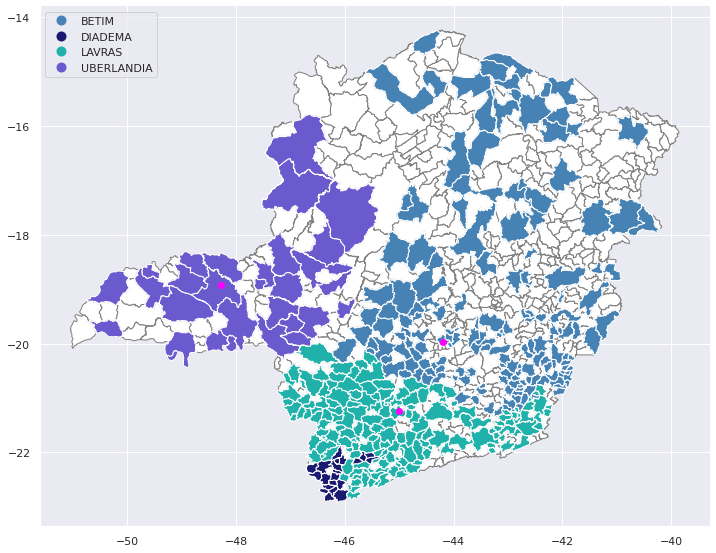

In [107]:
ax = county_df.plot(figsize=(12, 12), color='white', edgecolor='gray')
distributions_geo_.plot(column='MelhorCD', legend=True, legend_kwds={'loc':'upper left'}, ax=ax, cmap=map_palette)
distributions_geo_.plot(column='MelhorCD', legend=True, legend_kwds={'loc':'upper left'}, ax=ax, cmap=map_palette)
distributions_geo_.plot(column='MelhorCD', legend=True, legend_kwds={'loc':'upper left'}, ax=ax, cmap=map_palette)
distributions_centers.plot(color='magenta', ax=ax)
sns.despine()

```{admonition} Nota
:class: note
Foram encontrados alguns registros de rotas que **ocorreram no mesmo dia** que possuem **dois centros de distribuição**, exemplos: 47753, 58482, 59080, 46696, 57704  
```